In [1]:
import pandas as pd

df = pd.read_table('train_en.tsv')
print(df)

                              sentence_id  \
0    b9e1635a-72aa-467f-86d6-f56ef09f62c3   
1    f99b5143-70d2-494a-a2f5-c68f10d09d0a   
2    4076639c-aa56-4202-ae0f-9d9217f8da68   
3    b057c366-698e-419d-a284-9b16d835c64e   
4    a5a9645e-7850-41ba-90a2-5def725cd5b8   
..                                    ...   
825  9a0f5eec-cc36-49b8-88eb-20ad2c056eaa   
826  73545884-adf8-480c-a8b5-e65128ba8e91   
827  a8825286-21a4-46c9-9410-c0e7e183d708   
828  c984fc97-2604-4690-a2c0-d748703663af   
829  1b79225e-db68-43ef-a025-544b23a6c058   

                                              sentence label  solved_conflict  
0    Gone are the days when they led the world in r...  SUBJ             True  
1    The trend is expected to reverse as soon as ne...   OBJ            False  
2               But there is the specious point again.   OBJ            False  
3    He added he wouldn’t be surprised to see a new...   OBJ            False  
4    Not less government, you see; the same amount ...  SUB

In [2]:
print(f"befor encoding: {df['label'].dtype}")

mapping = {'SUBJ': 0, 'OBJ': 1}
df['label'] = df['label'].map(mapping)

print(f"after encoding: {df['label'].dtype}")

befor encoding: object
after encoding: int64


In [3]:
import re

def clean_scentence(scentence):
  clean = re.sub(r'[^a-zA-Z0-9]', ' ', scentence)
  clean = re.sub('\s+',' ',clean)
  striped = clean.strip("\"\t ")
  low = striped.lower()

  return low

In [4]:
df['sentence'] = df['sentence'].apply(lambda x: clean_scentence(x))

In [5]:
print(df['sentence'].head())

0    gone are the days when they led the world in r...
1    the trend is expected to reverse as soon as ne...
2                but there is the specious point again
3    he added he wouldn t be surprised to see a new...
4    not less government you see the same amount of...
Name: sentence, dtype: object


In [6]:
! pip install -U datasets transformers[torch] evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
!pip install datasets

In [8]:
from datasets import Dataset

hf_dataset = Dataset.from_pandas(df)

In [9]:
print(hf_dataset)
print(hf_dataset[0])

Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
    num_rows: 830
})
{'sentence_id': 'b9e1635a-72aa-467f-86d6-f56ef09f62c3', 'sentence': 'gone are the days when they led the world in recession busting', 'label': 0, 'solved_conflict': True}


In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')

def tokenize(row):
    tokens = word_tokenize(row['sentence'])
    # Convert tokens to lowercase and remove punctuation
    tokens = [token.lower() for token in tokens if token.isalpha()]
    return {'tokens': tokens}

def remove_stopwords(row):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in row['tokens'] if token not in stop_words]
    return {'tokens': tokens}

def apply_stemming(row):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in row['tokens']]
    return {'tokens': stemmed_tokens}

# Applying the tokenization function
hf_dataset = hf_dataset.map(tokenize)

# Removing stopwords
hf_dataset = hf_dataset.map(remove_stopwords)

# Applying stemming
hf_dataset = hf_dataset.map(apply_stemming)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Parameter 'function'=<function remove_stopwords at 0x7af335907760> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

In [11]:
from gensim.models import Word2Vec
word_embedding = Word2Vec(hf_dataset['tokens'], vector_size=100,
min_count=1, window=5, sg=1, hs=0, negative=10)

In [ ]:
word_embedding.save('w2v.model')
word_embedding = Word2Vec.load('w2v.model')

In [13]:
def filter_tokens(example):
  return {
  'tokens': [token for token in example['tokens'] if token in
  word_embedding.wv]
  }
def mean_vector(example):
  return {
'mean': word_embedding.wv[example['tokens']].mean(axis=0)
}

hf_dataset = hf_dataset.map(filter_tokens) \
                            .filter(lambda e: len(e['tokens']) > 0) \
                            .map(mean_vector)
print(hf_dataset)

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Filter:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean'],
    num_rows: 828
})


In [ ]:
splits = hf_dataset.train_test_split(test_size=0.2)

train_val_splits = splits['train'].train_test_split(test_size=0.25)

train_dataset = train_val_splits['train']
val_dataset = train_val_splits['test']
test_dataset = splits['test']

print("Training set:", train_dataset)
print("Validation set:", val_dataset)
print("Testing set:", test_dataset)

Training set: Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean'],
    num_rows: 496
})
Validation set: Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean'],
    num_rows: 166
})
Testing set: Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean'],
    num_rows: 166
})


In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB

X = np.array(splits['train']['mean'])
y = np.array(splits['train']['label'])

# LSTM

In [70]:
def vectorize(example):
  return {
  'vectors': word_embedding.wv[example['tokens']]
  }
hf_dataset = hf_dataset.map(vectorize)
print(hf_dataset)

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
    num_rows: 828
})


In [71]:
def word_to_index(example):
  indices = [word_embedding.wv.key_to_index[token] for token in
  example['tokens']]
  return {
  'indices': indices
  }
hf_dataset = hf_dataset.map(word_to_index)
print(hf_dataset)

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
    num_rows: 828
})


In [72]:
import numpy as np

pad_vector = np.zeros(word_embedding.vector_size)
weights = np.vstack([word_embedding.wv.vectors, pad_vector])
vocab_size, embedding_size = weights.shape
pad_idx = vocab_size - 1

In [73]:
import torch
import torch.nn as nn

def pad_sequences(batch):
  indices = [torch.tensor(sample, dtype=torch.long) for sample in
  batch['indices']]
  indices = nn.utils.rnn.pad_sequence(indices, batch_first=True,
  padding_value=pad_idx)
  return {
  'indices': indices
  }
hf_dataset = hf_dataset.map(pad_sequences, batched=True,
batch_size=None).with_format('torch')
print(hf_dataset)

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
    num_rows: 828
})


<ipython-input-73-325947f73394>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices = [torch.tensor(sample, dtype=torch.long) for sample in


In [88]:
import torch.nn.functional as F

class SentimentClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embeddings = self.embedding(x)
        out, _ = self.lstm(embeddings)
        out = out[:, -1, :]
        out = self.fc(out)
        out = F.sigmoid(out)
        return out.squeeze(1)

In [96]:
hidden_size = 128
num_layers = 2

model = SentimentClassifierLSTM(vocab_size=vocab_size,
                                embedding_size=embedding_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers)
model.embedding.weight = nn.Parameter(torch.FloatTensor(weights))
model.embedding.weight.requires_grad = False

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [98]:
from datasets import DatasetDict
import random

random_seed = 42


splits = hf_dataset.train_test_split(test_size=0.2, seed=random_seed)

train_val_splits = splits['train'].train_test_split(test_size=0.25, seed=random_seed)

final_splits = DatasetDict({
    'train': train_val_splits['train'],
    'validation': train_val_splits['test'],
    'test': splits['test']
})

print(final_splits)

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
        num_rows: 496
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
        num_rows: 166
    })
    test: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices'],
        num_rows: 166
    })
})


In [99]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 100

def to_dataloader(dataset, split, shuffle):
    dataset = TensorDataset(dataset[split]['indices'], dataset[split]['label'])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = to_dataloader(final_splits, 'train', True)
test_dataloader = to_dataloader(final_splits, 'test', False)
validation_dataloader = to_dataloader(final_splits, 'validation', False)

In [100]:
def train_one_epoch(dataloader):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_dataloader)

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
        validation_accuracy = total_correct / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [2/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [3/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [4/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [5/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [6/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [7/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [8/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [9/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [10/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [11/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [12/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [13/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [14/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [15/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
Epoch [16/50], Train Loss: 0.0067, Validation Accuracy: 0.3133
E

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

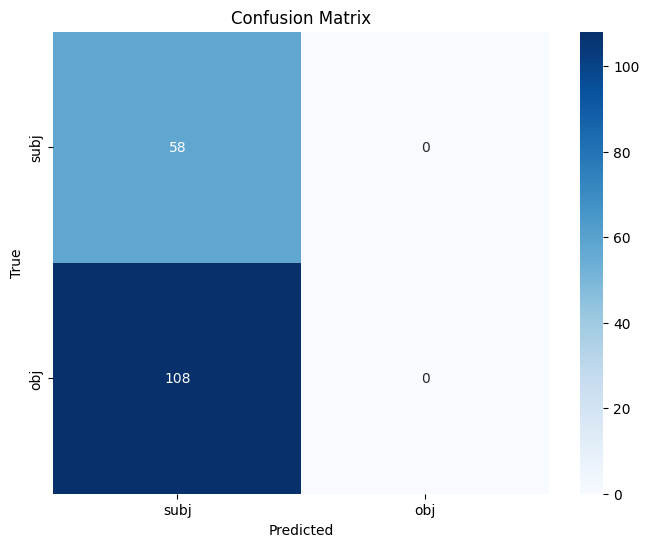

Test Accuracy: 0.3493975903614458
Confusion Matrix:
[[ 58   0]
 [108   0]]


In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)

            predicted_labels = (outputs > 0.5).float()

            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

    accuracy = total_correct / total_samples

    conf_matrix = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(conf_matrix, class_names=['subj', 'obj'])
    return accuracy, conf_matrix

test_accuracy, test_conf_matrix = evaluate_model(test_dataloader)

print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(test_conf_matrix)

In [103]:
# Calculate metrics from confusion matrix
total_samples = np.sum(test_conf_matrix)
true_positives = np.diag(test_conf_matrix)  # Diagonal elements
false_positives = np.sum(test_conf_matrix, axis=0) - true_positives
false_negatives = np.sum(test_conf_matrix, axis=1) - true_positives

# Accuracy
accuracy = np.sum(true_positives) / total_samples

# Micro-averaged Precision
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)

# Micro-averaged Recall
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Micro-averaged F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

accuracy: 0.3493975903614458
precision: 0.3493975903614458
recall: 0.3493975903614458
f1_score: 0.3493975903614458


# Transformers

In [45]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('lyeonii/bert-mini')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('lyeonii/bert-mini')

tokenized_dataset = hf_dataset.map(lambda x: tokenizer(
    x['sentence'],
    padding=True,
    return_tensors='pt'
), batched=True, batch_size=None).with_format('torch')


Map:   0%|          | 0/828 [00:00<?, ? examples/s]

In [47]:
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

In [61]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('lyeonii/bert-mini', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
print(tokenized_dataset)

Dataset({
    features: ['sentence_id', 'sentence', 'labels', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 828
})


In [50]:
from datasets import DatasetDict
import random

random_seed = 42


splits = tokenized_dataset.train_test_split(test_size=0.2, seed=random_seed)

train_val_splits = splits['train'].train_test_split(test_size=0.25, seed=random_seed)

tokenized_dataset = DatasetDict({
    'train': train_val_splits['train'],
    'validation': train_val_splits['test'],
    'test': splits['test']
})

print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence', 'labels', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 496
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence', 'labels', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
    test: Dataset({
        features: ['sentence_id', 'sentence', 'labels', 'solved_conflict', 'tokens', 'mean', 'vectors', 'indices', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 166
    })
})


In [64]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='sentiment-analysis',
    num_train_epochs=15,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    weight_decay=0.01,
    optim='sgd',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.531300,1.511780
2,1.526600,1.510100
3,1.524900,1.508561
4,1.517800,1.507137
5,1.521100,1.505842
6,1.515800,1.504665
7,1.520100,1.503612
8,1.514600,1.502681
9,1.510100,1.501884
10,1.512700,1.501196


TrainOutput(global_step=75, training_loss=1.5180617396036784, metrics={'train_runtime': 12.7996, 'train_samples_per_second': 581.27, 'train_steps_per_second': 5.86, 'total_flos': 15410701330560.0, 'train_loss': 1.5180617396036784, 'epoch': 15.0})

## evaluation:

In [52]:
! pip install evaluate

In [65]:
from transformers import Trainer, TrainingArguments
import evaluate

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print("Validation Accuracy:", results["eval_accuracy"])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.733071,0.686747
2,No log,0.649580,0.759036
3,No log,0.581679,0.753012
4,No log,0.551632,0.759036
5,No log,0.562991,0.765060
6,No log,0.562818,0.771084
7,No log,0.582637,0.771084
8,No log,0.602022,0.777108
9,No log,0.608644,0.771084
10,No log,0.610592,0.777108


Validation Accuracy: 0.7771084337349398


Test Accuracy: 0.7469879518072289


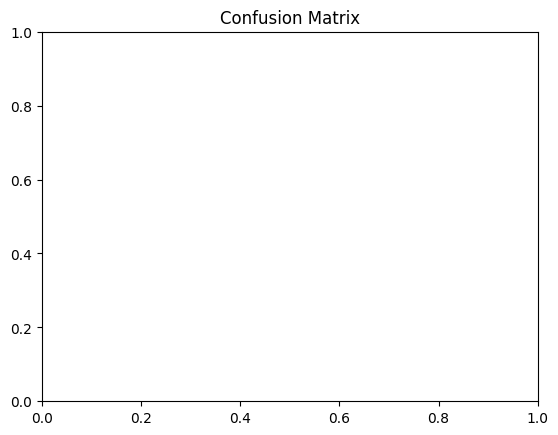

In [68]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import evaluate
import numpy as np
import matplotlib.pyplot as plt

test_dataset = tokenized_dataset['test']

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

test_results = trainer.predict(test_dataset)

predictions = test_results.predictions.argmax(axis=1)
labels = test_results.label_ids

accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print("Test Accuracy:", accuracy["accuracy"])

cm = confusion_matrix(labels, predictions)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label)
# disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [67]:
total_samples = np.sum(cm)
true_positives = np.diag(cm)
false_positives = np.sum(cm, axis=0) - true_positives
false_negatives = np.sum(cm, axis=1) - true_positives

# Accuracy
accuracy = np.sum(true_positives) / total_samples

# Micro-averaged Precision
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)

# Micro-averaged Recall
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Micro-averaged F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

accuracy: 0.7469879518072289
precision: 0.7469879518072289
recall: 0.7469879518072289
f1_score: 0.7469879518072289
